In [1]:
# | output: false
# Setup Notebook

path = "../../../../scripts/notebook_header.py"
import os


if os.path.basename(os.getcwd()) != "mtg-modeling":
    args = f"--path {path}"
    get_ipython().run_line_magic("run", f"-i {path} {args}")  # type: ignore

Changed working directory to: D:\mtg-modeling


In [22]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import src.plots.annotate as anno
import src.plots.symbols as symbols

In [3]:
set_code = "All_Sets"
set_codes_order = ["MKM", "OTJ", "MH3", "BLB"]

paths = {
    "processed": Path("data/processed/17lands/game_data/premier_draft"),
}
summary_file = paths["processed"] / f"{set_code}_Game_PD_Summary.parquet"
game_file = paths["processed"] / f"{set_code}_Game_PD_Games.parquet"
draft_file = paths["processed"] / f"{set_code}_Game_PD_Drafts.parquet"
card_file = paths["processed"] / f"{set_code}_Game_PD_Cards.parquet"

In [4]:
df_draft = pl.scan_parquet(draft_file)
df_summary = pl.scan_parquet(summary_file)

# Introduction

To assess player skill, I plotted the number of wins by player rank. While I don’t have player IDs to track individual performance, this view provides an average performance snapshot of the player base. Additionally, since I cannot track the number of drafts per player, more frequent players will be over-represented in the data.

Although opponent rankings are not available, we can infer that most opponents are of similar rank due to Arena’s draft system, which matches players with similar records. Each ranked season lasts about a month, and ranks experience "rank decay" between seasons. This decay means that at the start of a new season, a player's rank is lower, requiring them to play more games to regain their previous standing.

Therefore, our snapshot of each rank includes a mix of lower-skill players who have reached their peak at the end of the season and higher-skill players at the start of the season who are climbing back up the ranks.

This is a part of the MTG Arena draft analysis.  See the [Draft Introduction](00-intro.ipynb) for more information.  

# Player Rank

In @fig-rank-games we see that most drafts are played in the Platinum ranking.  This indicates the 17Lands player base is good, with more Mythic drafts recorded than Bronze drafts. 

In [5]:
draft_rank = (
    df_draft.group_by("rank")
    .agg(
        pl.col("n_wins").len().alias("len"),
        pl.col("n_wins").sum(),
        pl.col("n_games").sum(),
    )
    .sort(by="n_wins", descending=True)
)

ordered_ranks = {
    0: "bronze",
    1: "silver",
    2: "gold",
    3: "platinum",
    4: "diamond",
    5: "mythic",
}

ordered_ranks_df = pl.LazyFrame(
    {"rank_value": list(ordered_ranks.keys()), "rank": list(ordered_ranks.values())}
).with_columns(
    # Create the rank_name column
    (pl.col("rank_value").cast(str) + " " + pl.col("rank").str.to_uppercase()).alias(
        "rank_name"
    )
)

ranks = (
    ordered_ranks_df.join(draft_rank, on="rank", how="left")
    .sort("rank_value")
    .collect()  # Execute the lazy frame
).to_pandas()

ranks["win_rate"] = ranks["n_wins"] / ranks["n_games"]

In [6]:
mean_win_rate = df_summary.collect().to_pandas()["win_rate"].values[0]
# print(f"Average Win Percentage: {mean_win_rate:0.2%}")

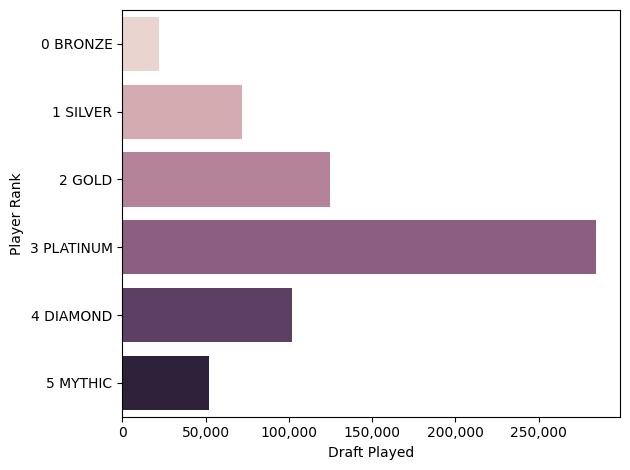

In [7]:
# | label: fig-rank-games
# | fig-cap: "Drafts Played by Players of Different Ranks."

sns.barplot(data=ranks, y="rank_name", x="len", hue="rank_value", legend=False)
anno.set_labels_to_commas()
anno.set_axis_labels_and_show(xlabel="Draft Played", ylabel="Player Rank")

# Win Rate by Rank

In @fig-ranks-win-rate, we observe that win rates vary by rank, with higher ranks generally achieving higher win rates. The Bronze rank has by far the lowest win rate, reflecting new or less skilled players. Interestingly, the Silver rank shows the highest win rate, likely due to the influx of Gold and Platinum players who reset to Silver at the start of the season and quickly climb back up the ranks.

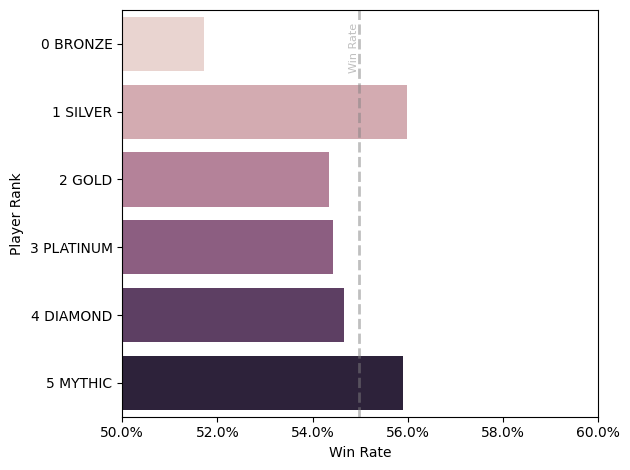

In [23]:
# | label: fig-ranks-win-rate
# | fig-cap: "Win Rate by Players of Different Ranks."

sns.barplot(data=ranks, y="rank_name", x="win_rate", hue="rank_value", legend=False)
plt.gca().set(xlim=(0.5, 0.60))

anno.plot_vert_line(x=mean_win_rate, label="Win Rate", y_pos=0.01, offset=-0.01)
anno.set_labels_to_percent()
anno.set_axis_labels_and_show(xlabel="Win Rate", ylabel="Player Rank")

# Last Week Win Rate

To account for players getting used to new sets, I plotted the win rate for the last week of set play compared to the earlier timeframes. In @fig-ranked-win-rate-over-time, we see a decline in win rates for higher ranks. This pattern suggests that higher ranks may become more competitive as the season progresses, while lower ranks tend to become more casual.


In [9]:
max_date = df_draft.select(pl.col("draft_time").max()).collect().to_series()[0]

draft_rank = (
    df_draft.with_columns(
        (pl.col("draft_time") >= (max_date - pl.duration(days=6))).alias("last_week")
    )
    .group_by(["rank", "last_week"])
    .agg(
        pl.col("n_wins").len().alias("len"),
        pl.col("n_wins").sum(),
        pl.col("n_games").sum(),
    )
    .sort(by="n_wins", descending=True)
)


week_ranks = (
    ordered_ranks_df.join(draft_rank, on="rank", how="left")
    .sort("rank_value")
    .collect()  # Execute the lazy frame
).to_pandas()

week_ranks["win_rate"] = week_ranks["n_wins"] / week_ranks["n_games"]

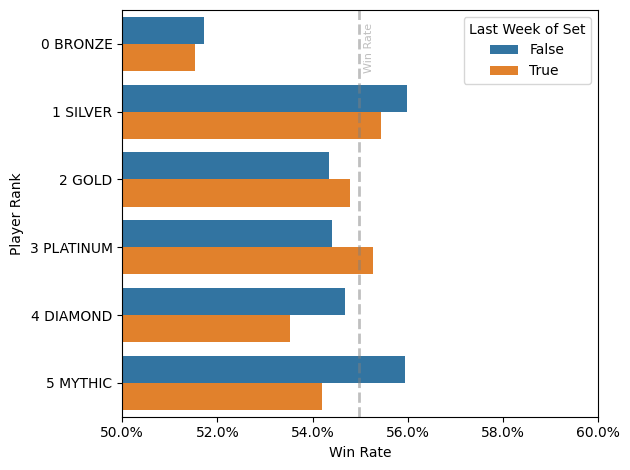

In [24]:
# | label: fig-ranked-win-rate-over-time
# | fig-cap: "Win Rate by Players of Different Ranks by Timeframe."

sns.barplot(data=week_ranks, y="rank_name", x="win_rate", hue="last_week")
plt.gca().set(xlim=(0.5, 0.60))

anno.plot_vert_line(x=mean_win_rate, label="Win Rate", y_pos=0.01, offset=0.02)
anno.set_labels_to_percent()
anno.set_axis_labels_and_show(
    xlabel="Win Rate",
    ylabel="Player Rank",
    legend=True,
    legend_title="Last Week of Set",
)

# Speed of Play

@fig-ranked-n-games shows the number of games played per draft for each rank. We see that more advanced players typically have longer games.

In [11]:
ranks["games_per_draft"] = ranks["n_games"] / ranks["len"]
mean_games_played = df_draft.select(pl.col("n_games").mean()).collect().to_numpy()[0][0]

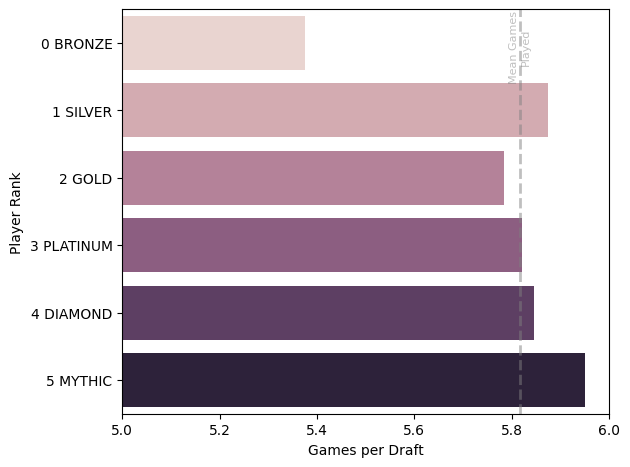

In [12]:
# | label: fig-ranked-n-games
# | fig-cap: "Games Played per Draft by Players of Different Ranks."

sns.barplot(
    data=ranks, y="rank_name", x="games_per_draft", hue="rank_value", legend=False
)
plt.gca().set(xlim=(5, 6))

anno.plot_vert_line(
    x=mean_games_played, label="Mean Games\nPlayed", y_pos=0.01, offset=0.0
)
anno.set_axis_labels_and_show(xlabel="Games per Draft", ylabel="Player Rank")

# Ranks over Time

We then examine the number of drafts played at each rank over time in @fig-ranked-drafts-over-time. I select to use the BLB set, since it was the latest release. 

The initial days are chaotic, with the BLB set launching on 07-30, and 07-31 being the first full day of recorded games. On 08-01, the new ranked season began, causing rank decay, which is especially noticeable in Mythic and Diamond gameplay.

Starting on 08-01, we observe distinct patterns: Gold rapidly declines after an initial peak of 3,800 drafts per day. Platinum peaks during days 4-6 before dropping. Diamond shows a slower climb with a plateau between days 8-13, followed by a gradual decline. Mythic starts at zero and slowly climbs, reaching a peak of 500 drafts per day around days 13-16.

From this chart, it's unclear how much of the decline at each rank is due to player advancement versus a loss of interest after the initial excitement of a new season. In the following charts, I will normalize the data to the total drafts played to better account for the overall decrease in gameplay.


In [157]:
def calcu_timeseries(df_draft):
    rank_time_df = (

        df_draft.group_by(
            pl.col("draft_time").dt.truncate("1d")  # Truncate datetime to day
        )
        .agg(
            [
                pl.col("rank")
                .value_counts()
                .alias("rank_counts")  # Count occurrences of each rank
            ]
        )
        .explode("rank_counts")
        .with_columns(
            # Extract rank and count from the exploded struct
            pl.col("rank_counts").struct.field("rank").alias("rank"),
            pl.col("rank_counts").struct.field("count").alias("count"),
        )
        .drop("rank_counts")
        .join(ordered_ranks_df, on="rank", how="left")
        .sort(by=["draft_time", "rank_name"], descending=False)
        .collect()
        .to_pandas()
    )

    # trim partial first day
    rank_time_df = rank_time_df.loc[
        rank_time_df["draft_time"] > rank_time_df["draft_time"].min()
    ]

    first_days = rank_time_df["draft_time"][
        rank_time_df["draft_time"].dt.is_month_start
    ].drop_duplicates()

    return rank_time_df, first_days

In [185]:
set_code2 = "BLB"
draft_file2 = paths["processed"] / f"{set_code2}_Game_PD_Drafts.parquet"
df_draft2 = pl.scan_parquet(draft_file2)
rank_time_df2, first_days = calcu_timeseries(df_draft2)

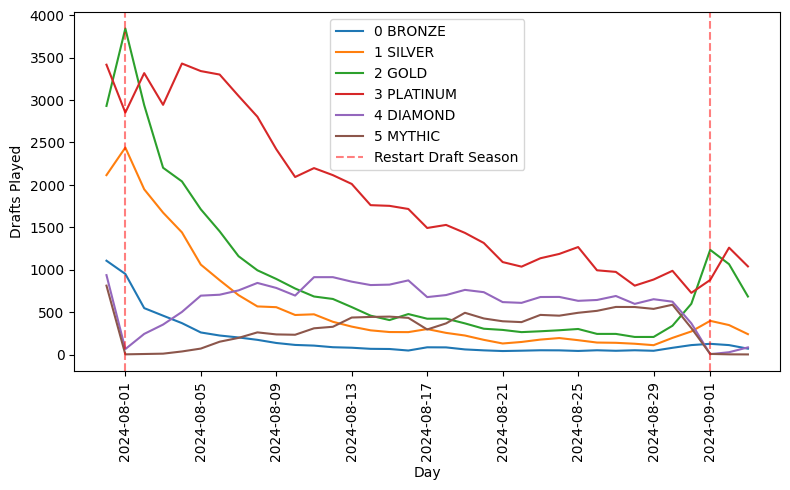

In [159]:
# | label: fig-ranked-drafts-over-time
# | fig-cap: "Drafts Played by Players Over Time, by Player rank for BLB set."

plt.figure(figsize=(8, 5))
sns.lineplot(data=rank_time_df2, x="draft_time", y="count", hue="rank_name")

for i, date in enumerate(first_days):
    if i == 0:
        label = "Restart Draft Season"
    else:
        label = None
    plt.axvline(
        x=date,
        color="red",
        linestyle="--",
        label=label,
        alpha=0.5,
    )

anno.set_axis_labels_and_show(
    xlabel="Day", ylabel="Drafts Played", legend=True, rot_x=True
)

## Total Play Across Sets

In @fig-ranked-total-drafts-over-time, we see the number of drafts played over time across multiple sets. Note that where data is missing, the values are imputed as zeros.

It is very clear that player engagement is most largely impacted with new set releases.  After a release date, the engagement declines nearly monotonically.  

It is interesting that a new season restart only has a small effect on player engagement. Small increases in player use is also observed on Saturdays.

This data highlights the economic motivation for releasing new sets to drive digital engagement on Arena, and it’s likely that paper play would follow a similar trend, with increased draft activity consuming more booster packs in the weeks following a new set’s launch.

For each set, BLB has the largest engagement followed by OTJ.  MKM and MH3 have less engagement, indicating the fan base is not as interested in these sets. 

In [160]:
set_code = "All_Sets"
draft_file = paths["processed"] / f"{set_code}_Game_PD_Drafts.parquet"
df_draft = pl.scan_parquet(draft_file)
rank_time_df, first_days = calcu_timeseries(df_draft)

full_date_range = pd.date_range(
    start=rank_time_df["draft_time"].min(),
    end=rank_time_df["draft_time"].max(),
    freq="D",
)

rank_time_df2 = rank_time_df.set_index("draft_time")
rank_time_df2 = rank_time_df2.pivot(columns="rank_name", values="count")
rank_time_df2 = rank_time_df2.reindex(full_date_range).reset_index()
rank_time_df2 = rank_time_df2.melt(
    value_name="count", var_name="rank_name", id_vars="index"
)
rank_time_df2 = rank_time_df2.rename(columns={"index": "draft_time"})
rank_time_df2 = rank_time_df2.sort_values(by=["draft_time", "rank_name"])
rank_time_df2["count"] = rank_time_df2["count"].fillna(0)

rank_time_sum = (
    rank_time_df2[["draft_time", "count"]].groupby(["draft_time"]).sum().reset_index()
)

In [161]:
set_days = {
    "MKM": pd.to_datetime("2024-02-07"),
    "OTJ": pd.to_datetime("2024-04-16"),
    "MH3": pd.to_datetime("2024-06-11"),
    "BLB": pd.to_datetime("2024-07-30"),
}

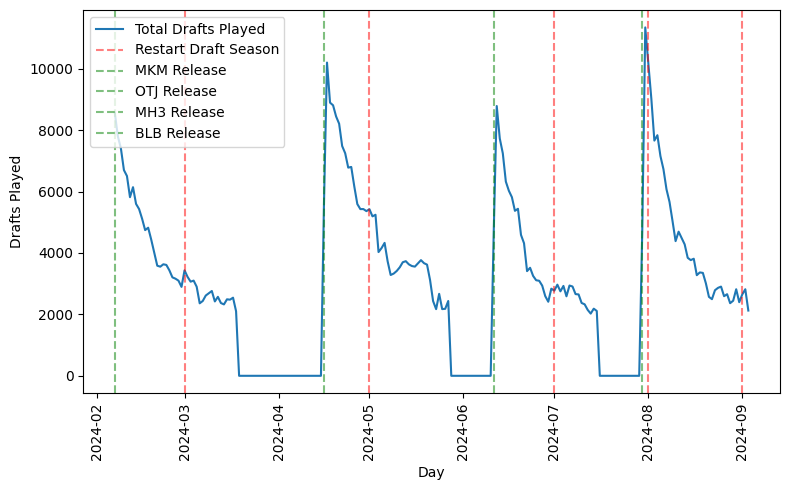

In [162]:
# | label: fig-ranked-total-drafts-over-time
# | fig-cap: "Total Drafts Played by Players Over Time across Sets."

plt.figure(figsize=(8, 5))
sns.lineplot(data=rank_time_sum, x="draft_time", y="count", label="Total Drafts Played")

plt.xlim = (pd.to_datetime("2024-07-29"), rank_time_sum["draft_time"].max())
plt.ylim = (0, 12000)

for i, date in enumerate(first_days):
    if i == 0:
        label = "Restart Draft Season"
    else:
        label = None
    plt.axvline(
        x=date,
        color="red",
        linestyle="--",
        label=label,
        alpha=0.5,
    )

for i, (name, date) in enumerate(set_days.items()):

    label = f"{name} Release"
    plt.axvline(
        x=date,
        color="green",
        linestyle="--",
        label=label,
        alpha=0.5,
    )

anno.set_axis_labels_and_show(
    xlabel="Day", ylabel="Drafts Played", legend=True, rot_x=True
)

## Normalized Rank Play

Next, we normalize for the total games played to observe the relative ranked play across the player base, as shown in @fig-normalized-ranked-drafts-over-time.

This normalization highlights the relative activity at each rank more clearly. After the season starts, Gold exhibits a linear decay as players progress to Platinum. Platinum maintains a prolonged plateau, indicating a balance between new players entering the rank and existing players advancing.

Diamond and Mythic both start with minimal participation but gradually increase in play almost monotonically, albeit at different rates.

In [186]:
set_code2 = "BLB"
draft_file2 = paths["processed"] / f"{set_code2}_Game_PD_Drafts.parquet"
df_draft2 = pl.scan_parquet(draft_file2)
rank_time_df2, first_days = calcu_timeseries(df_draft2)

rank_time_df2 = rank_time_df2.merge(
    rank_time_sum, on="draft_time", suffixes=("", "_sum")
)


rank_time_df2["rank_pct"] = rank_time_df2["count"] / rank_time_df2["count_sum"]
rank_time_df2["rank_pct"] = rank_time_df2["rank_pct"].fillna(0)

In [193]:
# mask = rank_time_df2["rank_name"].isin(["4 DIAMOND", "3 PLATINUM", "2 GOLD"])
# rank_time_df2 = rank_time_df2.loc[mask]

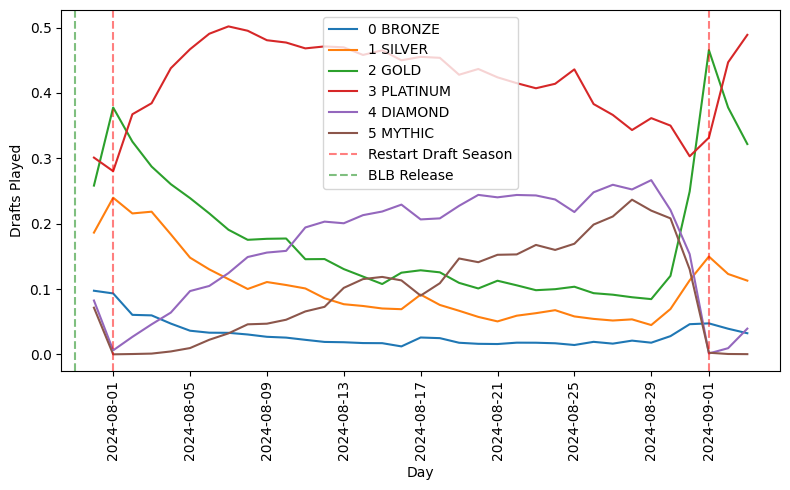

In [194]:
# | label: fig-normalized-ranked-drafts-over-time
# | fig-cap: "Normalized Drafts Played by Players of Different Ranks Over Time."

min_date = pd.to_datetime("2024-07-07")
max_date = pd.to_datetime("2024-09-30")

plt.figure(figsize=(8, 5))
sns.lineplot(data=rank_time_df2, x="draft_time", y="rank_pct", hue="rank_name")

for i, date in enumerate(first_days):
    if i == 0:
        label = "Restart Draft Season"
    else:
        label = None
    if date > min_date and date < max_date:
        plt.axvline(
            x=date,
            color="red",
            linestyle="--",
            label=label,
            alpha=0.5,
        )

for i, (name, date) in enumerate(set_days.items()):

    label = f"{name} Release"
    if date > min_date and date < max_date:
        plt.axvline(
            x=date,
            color="green",
            linestyle="--",
            label=label,
            alpha=0.5,
        )
# plt.gca().set_xlim([min_date, max_date])
anno.set_axis_labels_and_show(
    xlabel="Day", ylabel="Drafts Played", legend=True, rot_x=True
)

# Conclusion

As we have seen, the player ranks are impacted by several factors.  The major one is the seasonal decay in each new month.  As the month progresses, the player ranks adjust to reach a longer term equilibrium.

Looking at player engagement over time, we see the release of new sets is by far the most important.  The new season starts have minimal impact on increasing player engagement, at least directly.